In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'FreeHandV3'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

SNR_LOWER_BOUND = config.getint('DatasetValues', 'SnrLowerBound')

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


## Filter dataset to get only HIGH SNR datapoints

In [7]:
dataset_df = datasetlib.filter_dataset_for_high_snr_only(dataset_df, SNR_LOWER_BOUND)

# Neural network

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(82500, 2, 128)
[2, 128]


In [11]:
model = neural_networks.freehand_v3(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 128, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 128, 16)        64        
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


 1/81 [..............................] - ETA: 18:16 - loss: 2.9482

 2/81 [..............................] - ETA: 5s - loss: 2.8368   

 3/81 [>.............................] - ETA: 5s - loss: 2.7619

 4/81 [>.............................] - ETA: 5s - loss: 2.6966

 5/81 [>.............................] - ETA: 4s - loss: 2.6441

 6/81 [=>............................] - ETA: 4s - loss: 2.5981

 7/81 [=>............................] - ETA: 4s - loss: 2.5585

 8/81 [=>............................] - ETA: 4s - loss: 2.5226



 9/81 [==>...........................] - ETA: 4s - loss: 2.4911

10/81 [==>...........................] - ETA: 4s - loss: 2.4621



11/81 [===>..........................] - ETA: 4s - loss: 2.4354



12/81 [===>..........................] - ETA: 4s - loss: 2.4100

13/81 [===>..........................] - ETA: 4s - loss: 2.3860

14/81 [====>.........................] - ETA: 4s - loss: 2.3631

15/81 [====>.........................] - ETA: 4s - loss: 2.3413

16/81 [====>.........................] - ETA: 4s - loss: 2.3204

17/81 [=====>........................] - ETA: 4s - loss: 2.3002

18/81 [=====>........................] - ETA: 4s - loss: 2.2809

19/81 [======>.......................] - ETA: 4s - loss: 2.2623

20/81 [======>.......................] - ETA: 3s - loss: 2.2444

21/81 [======>.......................] - ETA: 3s - loss: 2.2270

22/81 [=======>......................] - ETA: 3s - loss: 2.2100

23/81 [=======>......................] - ETA: 3s - loss: 2.1936

24/81 [=======>......................] - ETA: 3s - loss: 2.1776

25/81 [========>.....................] - ETA: 3s - loss: 2.1620

26/81 [========>.....................] - ETA: 3s - loss: 2.1468

27/81 [=========>....................] - ETA: 3s - loss: 2.1319

28/81 [=========>....................] - ETA: 3s - loss: 2.1174

29/81 [=========>....................] - ETA: 3s - loss: 2.1031

30/81 [==========>...................] - ETA: 3s - loss: 2.0892

31/81 [==========>...................] - ETA: 3s - loss: 2.0756

32/81 [==========>...................] - ETA: 3s - loss: 2.0623

33/81 [===========>..................] - ETA: 3s - loss: 2.0493

34/81 [===========>..................] - ETA: 3s - loss: 2.0365

35/81 [===========>..................] - ETA: 3s - loss: 2.0239

36/81 [============>.................] - ETA: 2s - loss: 2.0114

37/81 [============>.................] - ETA: 2s - loss: 1.9992

38/81 [=============>................] - ETA: 2s - loss: 1.9872

39/81 [=============>................] - ETA: 2s - loss: 1.9753

40/81 [=============>................] - ETA: 2s - loss: 1.9637

41/81 [==============>...............] - ETA: 2s - loss: 1.9522

42/81 [==============>...............] - ETA: 2s - loss: 1.9409

43/81 [==============>...............] - ETA: 2s - loss: 1.9298

44/81 [===============>..............] - ETA: 2s - loss: 1.9189

45/81 [===============>..............] - ETA: 2s - loss: 1.9081



46/81 [================>.............] - ETA: 2s - loss: 1.8975



47/81 [================>.............] - ETA: 2s - loss: 1.8870

48/81 [================>.............] - ETA: 2s - loss: 1.8767

49/81 [=================>............] - ETA: 2s - loss: 1.8665

50/81 [=================>............] - ETA: 2s - loss: 1.8564

51/81 [=================>............] - ETA: 1s - loss: 1.8466

52/81 [==================>...........] - ETA: 1s - loss: 1.8369

53/81 [==================>...........] - ETA: 1s - loss: 1.8273

54/81 [===================>..........] - ETA: 1s - loss: 1.8178

55/81 [===================>..........] - ETA: 1s - loss: 1.8085



56/81 [===================>..........] - ETA: 1s - loss: 1.7994

57/81 [====================>.........] - ETA: 1s - loss: 1.7903



58/81 [====================>.........] - ETA: 1s - loss: 1.7814



59/81 [====================>.........] - ETA: 1s - loss: 1.7726

60/81 [=====================>........] - ETA: 1s - loss: 1.7639

61/81 [=====================>........] - ETA: 1s - loss: 1.7554

62/81 [=====================>........] - ETA: 1s - loss: 1.7469

63/81 [======================>.......] - ETA: 1s - loss: 1.7386

64/81 [======================>.......] - ETA: 1s - loss: 1.7304

65/81 [=======================>......] - ETA: 1s - loss: 1.7224

66/81 [=======================>......] - ETA: 0s - loss: 1.7144

67/81 [=======================>......] - ETA: 0s - loss: 1.7065

68/81 [========================>.....] - ETA: 0s - loss: 1.6987

69/81 [========================>.....] - ETA: 0s - loss: 1.6911

70/81 [========================>.....] - ETA: 0s - loss: 1.6836

71/81 [=========================>....] - ETA: 0s - loss: 1.6761

72/81 [=========================>....] - ETA: 0s - loss: 1.6688

73/81 [==========================>...] - ETA: 0s - loss: 1.6615

74/81 [==========================>...] - ETA: 0s - loss: 1.6543

75/81 [==========================>...] - ETA: 0s - loss: 1.6472

76/81 [===========================>..] - ETA: 0s - loss: 1.6402

77/81 [===========================>..] - ETA: 0s - loss: 1.6333

78/81 [===========================>..] - ETA: 0s - loss: 1.6265



79/81 [============================>.] - ETA: 0s - loss: 1.6198

80/81 [============================>.] - ETA: 0s - loss: 1.6132

81/81 [==============================] - ETA: 0s - loss: 1.6066

81/81 [==============================] - 21s 87ms/step - loss: 1.6003 - val_loss: 4.2200


Epoch 2/100
 1/81 [..............................] - ETA: 5s - loss: 0.5557

 2/81 [..............................] - ETA: 5s - loss: 0.5512

 3/81 [>.............................] - ETA: 5s - loss: 0.5468

 4/81 [>.............................] - ETA: 4s - loss: 0.5433

 5/81 [>.............................] - ETA: 4s - loss: 0.5416

 6/81 [=>............................] - ETA: 4s - loss: 0.5407

 7/81 [=>............................] - ETA: 4s - loss: 0.5395

 8/81 [=>............................] - ETA: 4s - loss: 0.5384

 9/81 [==>...........................] - ETA: 4s - loss: 0.5376



10/81 [==>...........................] - ETA: 4s - loss: 0.5370

11/81 [===>..........................] - ETA: 4s - loss: 0.5364



12/81 [===>..........................] - ETA: 4s - loss: 0.5357

13/81 [===>..........................] - ETA: 4s - loss: 0.5349

14/81 [====>.........................] - ETA: 4s - loss: 0.5343

15/81 [====>.........................] - ETA: 4s - loss: 0.5339

16/81 [====>.........................] - ETA: 4s - loss: 0.5335

17/81 [=====>........................] - ETA: 4s - loss: 0.5332

18/81 [=====>........................] - ETA: 4s - loss: 0.5329

19/81 [======>.......................] - ETA: 4s - loss: 0.5327

20/81 [======>.......................] - ETA: 3s - loss: 0.5325

21/81 [======>.......................] - ETA: 3s - loss: 0.5322

22/81 [=======>......................] - ETA: 3s - loss: 0.5319

23/81 [=======>......................] - ETA: 3s - loss: 0.5317

24/81 [=======>......................] - ETA: 3s - loss: 0.5315

25/81 [========>.....................] - ETA: 3s - loss: 0.5313

26/81 [========>.....................] - ETA: 3s - loss: 0.5311

27/81 [=========>....................] - ETA: 3s - loss: 0.5309

28/81 [=========>....................] - ETA: 3s - loss: 0.5307

29/81 [=========>....................] - ETA: 3s - loss: 0.5305

30/81 [==========>...................] - ETA: 3s - loss: 0.5304

31/81 [==========>...................] - ETA: 3s - loss: 0.5303

32/81 [==========>...................] - ETA: 3s - loss: 0.5301

33/81 [===========>..................] - ETA: 3s - loss: 0.5300

34/81 [===========>..................] - ETA: 3s - loss: 0.5298

35/81 [===========>..................] - ETA: 3s - loss: 0.5296

36/81 [============>.................] - ETA: 2s - loss: 0.5295



37/81 [============>.................] - ETA: 2s - loss: 0.5293

38/81 [=============>................] - ETA: 2s - loss: 0.5291

39/81 [=============>................] - ETA: 2s - loss: 0.5290

40/81 [=============>................] - ETA: 2s - loss: 0.5288

41/81 [==============>...............] - ETA: 2s - loss: 0.5285



42/81 [==============>...............] - ETA: 2s - loss: 0.5283

43/81 [==============>...............] - ETA: 2s - loss: 0.5281

44/81 [===============>..............] - ETA: 2s - loss: 0.5278



45/81 [===============>..............] - ETA: 2s - loss: 0.5276

46/81 [================>.............] - ETA: 2s - loss: 0.5274

47/81 [================>.............] - ETA: 2s - loss: 0.5272

48/81 [================>.............] - ETA: 2s - loss: 0.5270

49/81 [=================>............] - ETA: 2s - loss: 0.5268

50/81 [=================>............] - ETA: 2s - loss: 0.5266

51/81 [=================>............] - ETA: 1s - loss: 0.5264

52/81 [==================>...........] - ETA: 1s - loss: 0.5262

53/81 [==================>...........] - ETA: 1s - loss: 0.5259

54/81 [===================>..........] - ETA: 1s - loss: 0.5257

55/81 [===================>..........] - ETA: 1s - loss: 0.5255

56/81 [===================>..........] - ETA: 1s - loss: 0.5253

57/81 [====================>.........] - ETA: 1s - loss: 0.5251

58/81 [====================>.........] - ETA: 1s - loss: 0.5249

59/81 [====================>.........] - ETA: 1s - loss: 0.5247

60/81 [=====================>........] - ETA: 1s - loss: 0.5245

61/81 [=====================>........] - ETA: 1s - loss: 0.5243

62/81 [=====================>........] - ETA: 1s - loss: 0.5240

63/81 [======================>.......] - ETA: 1s - loss: 0.5238

64/81 [======================>.......] - ETA: 1s - loss: 0.5236

65/81 [=======================>......] - ETA: 1s - loss: 0.5234

66/81 [=======================>......] - ETA: 0s - loss: 0.5232

67/81 [=======================>......] - ETA: 0s - loss: 0.5229

68/81 [========================>.....] - ETA: 0s - loss: 0.5227

69/81 [========================>.....] - ETA: 0s - loss: 0.5225

70/81 [========================>.....] - ETA: 0s - loss: 0.5223

71/81 [=========================>....] - ETA: 0s - loss: 0.5221

72/81 [=========================>....] - ETA: 0s - loss: 0.5219

73/81 [==========================>...] - ETA: 0s - loss: 0.5216

74/81 [==========================>...] - ETA: 0s - loss: 0.5214

75/81 [==========================>...] - ETA: 0s - loss: 0.5212

76/81 [===========================>..] - ETA: 0s - loss: 0.5210

77/81 [===========================>..] - ETA: 0s - loss: 0.5208

78/81 [===========================>..] - ETA: 0s - loss: 0.5205

79/81 [============================>.] - ETA: 0s - loss: 0.5203

80/81 [============================>.] - ETA: 0s - loss: 0.5201

81/81 [==============================] - 6s 73ms/step - loss: 0.5197 - val_loss: 6.1129


Epoch 3/100
 1/81 [..............................] - ETA: 5s - loss: 0.4136

 2/81 [..............................] - ETA: 5s - loss: 0.4205

 3/81 [>.............................] - ETA: 5s - loss: 0.4269

 4/81 [>.............................] - ETA: 5s - loss: 0.4303

 5/81 [>.............................] - ETA: 4s - loss: 0.4318

 6/81 [=>............................] - ETA: 4s - loss: 0.4328

 7/81 [=>............................] - ETA: 4s - loss: 0.4342

 8/81 [=>............................] - ETA: 4s - loss: 0.4356

 9/81 [==>...........................] - ETA: 4s - loss: 0.4367

10/81 [==>...........................] - ETA: 4s - loss: 0.4376

11/81 [===>..........................] - ETA: 4s - loss: 0.4382

12/81 [===>..........................]

 - ETA: 4s - loss: 0.4388

13/81 [===>..........................] - ETA: 4s - loss: 0.4394

14/81 [====>.........................] - ETA: 4s - loss: 0.4398

15/81 [====>.........................] - ETA: 4s - loss: 0.4403

16/81 [====>.........................] - ETA: 4s - loss: 0.4407

17/81 [=====>........................] - ETA: 4s - loss: 0.4410

18/81 [=====>........................] - ETA: 4s - loss: 0.4414

19/81 [======>.......................] - ETA: 4s - loss: 0.4417

20/81 [======>.......................] - ETA: 4s - loss: 0.4419

21/81 [======>.......................] - ETA: 3s - loss: 0.4421

22/81 [=======>......................] - ETA: 3s - loss: 0.4423

23/81 [=======>......................] - ETA: 3s - loss: 0.4425

24/81 [=======>......................] - ETA: 3s - loss: 0.4427

25/81 [========>.....................] - ETA: 3s - loss: 0.4429

26/81 [========>.....................] - ETA: 3s - loss: 0.4430

27/81 [=========>....................] - ETA: 3s - loss: 0.4431

28/81 [=========>....................] - ETA: 3s - loss: 0.4432

29/81 [=========>....................] - ETA: 3s - loss: 0.4432

30/81 [==========>...................] - ETA: 3s - loss: 0.4432

31/81 [==========>...................] - ETA: 3s - loss: 0.4433

32/81 [==========>...................] - ETA: 3s - loss: 0.4432

33/81 [===========>..................] - ETA: 3s - loss: 0.4432

34/81 [===========>..................] - ETA: 3s - loss: 0.4431

35/81 [===========>..................] - ETA: 3s - loss: 0.4431

36/81 [============>.................] - ETA: 2s - loss: 0.4431

37/81 [============>.................] - ETA: 2s - loss: 0.4431

38/81 [=============>................] - ETA: 2s - loss: 0.4431

39/81 [=============>................] - ETA: 2s - loss: 0.4431

40/81 [=============>................] - ETA: 2s - loss: 0.4431

41/81 [==============>...............] - ETA: 2s - loss: 0.4430

42/81 [==============>...............] - ETA: 2s - loss: 0.4430

43/81 [==============>...............] - ETA: 2s - loss: 0.4430

44/81 [===============>..............] - ETA: 2s - loss: 0.4430

45/81 [===============>..............] - ETA: 2s - loss: 0.4430

46/81 [================>.............] - ETA: 2s - loss: 0.4429

47/81 [================>.............] - ETA: 2s - loss: 0.4429

48/81 [================>.............] - ETA: 2s - loss: 0.4429

49/81 [=================>............] - ETA: 2s - loss: 0.4429

50/81 [=================>............] - ETA: 2s - loss: 0.4428

51/81 [=================>............] - ETA: 1s - loss: 0.4428

52/81 [==================>...........] - ETA: 1s - loss: 0.4427

53/81 [==================>...........] - ETA: 1s - loss: 0.4427

54/81 [===================>..........] - ETA: 1s - loss: 0.4426

55/81 [===================>..........] - ETA: 1s - loss: 0.4426

56/81 [===================>..........] - ETA: 1s - loss: 0.4425

57/81 [====================>.........] - ETA: 1s - loss: 0.4425

58/81 [====================>.........] - ETA: 1s - loss: 0.4424

59/81 [====================>.........] - ETA: 1s - loss: 0.4424

60/81 [=====================>........] - ETA: 1s - loss: 0.4423

61/81 [=====================>........] - ETA: 1s - loss: 0.4423

62/81 [=====================>........] - ETA: 1s - loss: 0.4422

63/81 [======================>.......] - ETA: 1s - loss: 0.4421

64/81 [======================>.......] - ETA: 1s - loss: 0.4421

65/81 [=======================>......] - ETA: 1s - loss: 0.4420

66/81 [=======================>......] - ETA: 0s - loss: 0.4419

67/81 [=======================>......] - ETA: 0s - loss: 0.4418

68/81 [========================>.....] - ETA: 0s - loss: 0.4417

69/81 [========================>.....] - ETA: 0s - loss: 0.4417

70/81 [========================>.....] - ETA: 0s - loss: 0.4416

71/81 [=========================>....] - ETA: 0s - loss: 0.4415

72/81 [=========================>....] - ETA: 0s - loss: 0.4414

73/81 [==========================>...] - ETA: 0s - loss: 0.4413

74/81 [==========================>...] - ETA: 0s - loss: 0.4413

75/81 [==========================>...] - ETA: 0s - loss: 0.4412

76/81 [===========================>..] - ETA: 0s - loss: 0.4411

77/81 [===========================>..] - ETA: 0s - loss: 0.4410

78/81 [===========================>..] - ETA: 0s - loss: 0.4409

79/81 [============================>.] - ETA: 0s - loss: 0.4408

80/81 [============================>.] - ETA: 0s - loss: 0.4407

81/81 [==============================] - 6s 73ms/step - loss: 0.4405 - val_loss: 7.4097


Epoch 4/100
 1/81 [..............................] - ETA: 5s - loss: 0.3923

 2/81 [..............................] - ETA: 5s - loss: 0.3928

 3/81 [>.............................] - ETA: 5s - loss: 0.3948

 4/81 [>.............................] - ETA: 5s - loss: 0.3970

 5/81 [>.............................] - ETA: 5s - loss: 0.3988

 6/81 [=>............................] - ETA: 4s - loss: 0.4008

 7/81 [=>............................] - ETA: 4s - loss: 0.4020

 8/81 [=>............................] - ETA: 4s - loss: 0.4025

 9/81 [==>...........................] - ETA: 4s - loss: 0.4025

10/81 [==>...........................] - ETA: 4s - loss: 0.4024

11/81 [===>..........................] - ETA: 4s - loss: 0.4023

12/81 [===>..........................] - ETA: 4s - loss: 0.4020

13/81 [===>..........................] - ETA: 4s - loss: 0.4018

14/81 [====>.........................] - ETA: 4s - loss: 0.4014

15/81 [====>.........................] - ETA: 4s - loss: 0.4012

16/81 [====>.........................] - ETA: 4s - loss: 0.4010

17/81 [=====>........................] - ETA: 4s - loss: 0.4008

18/81 [=====>........................] - ETA: 4s - loss: 0.4005

19/81 [======>.......................]

 - ETA: 4s - loss: 0.4002

20/81 [======>.......................] - ETA: 3s - loss: 0.4000

21/81 [======>.......................] - ETA: 3s - loss: 0.3997

22/81 [=======>......................]

 - ETA: 3s - loss: 0.3995

23/81 [=======>......................] - ETA: 3s - loss: 0.3992

24/81 [=======>......................] - ETA: 3s - loss: 0.3989

25/81 [========>.....................] - ETA: 3s - loss: 0.3986

26/81 [========>.....................] - ETA: 3s - loss: 0.3983

27/81 [=========>....................] - ETA: 3s - loss: 0.3980

28/81 [=========>....................] - ETA: 3s - loss: 0.3977

29/81 [=========>....................] - ETA: 3s - loss: 0.3975

30/81 [==========>...................] - ETA: 3s - loss: 0.3972

31/81 [==========>...................] - ETA: 3s - loss: 0.3969

32/81 [==========>...................] - ETA: 3s - loss: 0.3966

33/81 [===========>..................] - ETA: 3s - loss: 0.3964

34/81 [===========>..................] - ETA: 3s - loss: 0.3962

35/81 [===========>..................] - ETA: 3s - loss: 0.3959

36/81 [============>.................] - ETA: 2s - loss: 0.3957

37/81 [============>.................] - ETA: 2s - loss: 0.3955

38/81 [=============>................] - ETA: 2s - loss: 0.3952

39/81 [=============>................] - ETA: 2s - loss: 0.3950

40/81 [=============>................] - ETA: 2s - loss: 0.3948

41/81 [==============>...............] - ETA: 2s - loss: 0.3946

42/81 [==============>...............] - ETA: 2s - loss: 0.3944

43/81 [==============>...............] - ETA: 2s - loss: 0.3942

44/81 [===============>..............] - ETA: 2s - loss: 0.3940

45/81 [===============>..............] - ETA: 2s - loss: 0.3938

46/81 [================>.............] - ETA: 2s - loss: 0.3936

47/81 [================>.............] - ETA: 2s - loss: 0.3934

48/81 [================>.............] - ETA: 2s - loss: 0.3933

49/81 [=================>............] - ETA: 2s - loss: 0.3931

50/81 [=================>............] - ETA: 2s - loss: 0.3930

51/81 [=================>............] - ETA: 1s - loss: 0.3928

52/81 [==================>...........] - ETA: 1s - loss: 0.3927

53/81 [==================>...........] - ETA: 1s - loss: 0.3926

54/81 [===================>..........] - ETA: 1s - loss: 0.3924

55/81 [===================>..........] - ETA: 1s - loss: 0.3923

56/81 [===================>..........] - ETA: 1s - loss: 0.3922

57/81 [====================>.........] - ETA: 1s - loss: 0.3921

58/81 [====================>.........] - ETA: 1s - loss: 0.3920

59/81 [====================>.........] - ETA: 1s - loss: 0.3918

60/81 [=====================>........] - ETA: 1s - loss: 0.3917

61/81 [=====================>........] - ETA: 1s - loss: 0.3916

62/81 [=====================>........] - ETA: 1s - loss: 0.3915

63/81 [======================>.......] - ETA: 1s - loss: 0.3913

64/81 [======================>.......] - ETA: 1s - loss: 0.3912

65/81 [=======================>......] - ETA: 1s - loss: 0.3911

66/81 [=======================>......] - ETA: 0s - loss: 0.3910

67/81 [=======================>......] - ETA: 0s - loss: 0.3909

68/81 [========================>.....] - ETA: 0s - loss: 0.3908

69/81 [========================>.....] - ETA: 0s - loss: 0.3907

70/81 [========================>.....] - ETA: 0s - loss: 0.3906

71/81 [=========================>....] - ETA: 0s - loss: 0.3905

72/81 [=========================>....] - ETA: 0s - loss: 0.3903

73/81 [==========================>...] - ETA: 0s - loss: 0.3902

74/81 [==========================>...] - ETA: 0s - loss: 0.3901

75/81 [==========================>...] - ETA: 0s - loss: 0.3901

76/81 [===========================>..] - ETA: 0s - loss: 0.3900

77/81 [===========================>..] - ETA: 0s - loss: 0.3899

78/81 [===========================>..] - ETA: 0s - loss: 0.3898

79/81 [============================>.] - ETA: 0s - loss: 0.3897

80/81 [============================>.] - ETA: 0s - loss: 0.3896

81/81 [==============================] - 6s 73ms/step - loss: 0.3895 - val_loss: 7.2800


Epoch 5/100
 1/81 [..............................] - ETA: 5s - loss: 0.3821

 2/81 [..............................] - ETA: 5s - loss: 0.3772



 3/81 [>.............................] - ETA: 5s - loss: 0.3711

 4/81 [>.............................] - ETA: 5s - loss: 0.3681

 5/81 [>.............................] - ETA: 4s - loss: 0.3670

 6/81 [=>............................] - ETA: 4s - loss: 0.3658

 7/81 [=>............................] - ETA: 4s - loss: 0.3647

 8/81 [=>............................] - ETA: 4s - loss: 0.3641

 9/81 [==>...........................] - ETA: 4s - loss: 0.3636

10/81 [==>...........................] - ETA: 4s - loss: 0.3631

11/81 [===>..........................] - ETA: 4s - loss: 0.3627

12/81 [===>..........................] - ETA: 4s - loss: 0.3625

13/81 [===>..........................] - ETA: 4s - loss: 0.3622

14/81 [====>.........................] - ETA: 4s - loss: 0.3620

15/81 [====>.........................] - ETA: 4s - loss: 0.3619

16/81 [====>.........................] - ETA: 4s - loss: 0.3617

17/81 [=====>........................] - ETA: 4s - loss: 0.3616

18/81 [=====>........................] - ETA: 4s - loss: 0.3616

19/81 [======>.......................] - ETA: 4s - loss: 0.3614

20/81 [======>.......................] - ETA: 3s - loss: 0.3613

21/81 [======>.......................] - ETA: 3s - loss: 0.3612

22/81 [=======>......................] - ETA: 3s - loss: 0.3610

23/81 [=======>......................] - ETA: 3s - loss: 0.3609

24/81 [=======>......................] - ETA: 3s - loss: 0.3608

25/81 [========>.....................] - ETA: 3s - loss: 0.3607

26/81 [========>.....................] - ETA: 3s - loss: 0.3606

27/81 [=========>....................] - ETA: 3s - loss: 0.3606

28/81 [=========>....................] - ETA: 3s - loss: 0.3605

29/81 [=========>....................] - ETA: 3s - loss: 0.3604



30/81 [==========>...................] - ETA: 3s - loss: 0.3603

31/81 [==========>...................] - ETA: 3s - loss: 0.3602

32/81 [==========>...................] - ETA: 3s - loss: 0.3602

33/81 [===========>..................]

 - ETA: 3s - loss: 0.3601

34/81 [===========>..................] - ETA: 3s - loss: 0.3600



35/81 [===========>..................] - ETA: 3s - loss: 0.3600

36/81 [============>.................] - ETA: 2s - loss: 0.3599

37/81 [============>.................] - ETA: 2s - loss: 0.3598

38/81 [=============>................] - ETA: 2s - loss: 0.3597

39/81 [=============>................] - ETA: 2s - loss: 0.3597

40/81 [=============>................] - ETA: 2s - loss: 0.3596

41/81 [==============>...............] - ETA: 2s - loss: 0.3596

42/81 [==============>...............] - ETA: 2s - loss: 0.3595

43/81 [==============>...............] - ETA: 2s - loss: 0.3594

44/81 [===============>..............] - ETA: 2s - loss: 0.3594

45/81 [===============>..............] - ETA: 2s - loss: 0.3593

46/81 [================>.............] - ETA: 2s - loss: 0.3593

47/81 [================>.............] - ETA: 2s - loss: 0.3592

48/81 [================>.............] - ETA: 2s - loss: 0.3591

49/81 [=================>............] - ETA: 2s - loss: 0.3591

50/81 [=================>............] - ETA: 2s - loss: 0.3590

51/81 [=================>............] - ETA: 1s - loss: 0.3590

52/81 [==================>...........] - ETA: 1s - loss: 0.3589

53/81 [==================>...........] - ETA: 1s - loss: 0.3588

54/81 [===================>..........] - ETA: 1s - loss: 0.3588

55/81 [===================>..........] - ETA: 1s - loss: 0.3587

56/81 [===================>..........] - ETA: 1s - loss: 0.3587

57/81 [====================>.........] - ETA: 1s - loss: 0.3586

58/81 [====================>.........] - ETA: 1s - loss: 0.3586

59/81 [====================>.........] - ETA: 1s - loss: 0.3585

60/81 [=====================>........] - ETA: 1s - loss: 0.3585

61/81 [=====================>........] - ETA: 1s - loss: 0.3584

62/81 [=====================>........] - ETA: 1s - loss: 0.3584

63/81 [======================>.......] - ETA: 1s - loss: 0.3583

64/81 [======================>.......] - ETA: 1s - loss: 0.3583

65/81 [=======================>......] - ETA: 1s - loss: 0.3582

66/81 [=======================>......] - ETA: 0s - loss: 0.3582

67/81 [=======================>......] - ETA: 0s - loss: 0.3582

68/81 [========================>.....] - ETA: 0s - loss: 0.3581

69/81 [========================>.....] - ETA: 0s - loss: 0.3581

70/81 [========================>.....] - ETA: 0s - loss: 0.3580

71/81 [=========================>....] - ETA: 0s - loss: 0.3580

72/81 [=========================>....] - ETA: 0s - loss: 0.3580

73/81 [==========================>...] - ETA: 0s - loss: 0.3579

74/81 [==========================>...] - ETA: 0s - loss: 0.3579

75/81 [==========================>...] - ETA: 0s - loss: 0.3579

76/81 [===========================>..] - ETA: 0s - loss: 0.3578

77/81 [===========================>..] - ETA: 0s - loss: 0.3578

78/81 [===========================>..] - ETA: 0s - loss: 0.3578

79/81 [============================>.] - ETA: 0s - loss: 0.3577

80/81 [============================>.] - ETA: 0s - loss: 0.3577

81/81 [==============================] - 6s 73ms/step - loss: 0.3577 - val_loss: 6.8896


Epoch 6/100
 1/81 [..............................] - ETA: 5s - loss: 0.3286

 2/81 [..............................] - ETA: 5s - loss: 0.3343

 3/81 [>.............................] - ETA: 5s - loss: 0.3369

 4/81 [>.............................] - ETA: 5s - loss: 0.3394

 5/81 [>.............................] - ETA: 4s - loss: 0.3401

 6/81 [=>............................] - ETA: 4s - loss: 0.3401

 7/81 [=>............................] - ETA: 4s - loss: 0.3399

 8/81 [=>............................] - ETA: 4s - loss: 0.3397

 9/81 [==>...........................] - ETA: 4s - loss: 0.3395

10/81 [==>...........................] - ETA: 4s - loss: 0.3393

11/81 [===>..........................] - ETA: 4s - loss: 0.3390

12/81 [===>..........................] - ETA: 4s - loss: 0.3388

13/81 [===>..........................] - ETA: 4s - loss: 0.3386

14/81 [====>.........................] - ETA: 4s - loss: 0.3385

15/81 [====>.........................] - ETA: 4s - loss: 0.3384

16/81 [====>.........................] - ETA: 4s - loss: 0.3384

17/81 [=====>........................] - ETA: 4s - loss: 0.3384

18/81 [=====>........................] - ETA: 4s - loss: 0.3383

19/81 [======>.......................] - ETA: 4s - loss: 0.3383



20/81 [======>.......................] - ETA: 4s - loss: 0.3383



21/81 [======>.......................] - ETA: 3s - loss: 0.3382

22/81 [=======>......................] - ETA: 3s - loss: 0.3381

23/81 [=======>......................] - ETA: 3s - loss: 0.3380



24/81 [=======>......................] - ETA: 3s - loss: 0.3379

25/81 [========>.....................] - ETA: 3s - loss: 0.3378

26/81 [========>.....................] - ETA: 3s - loss: 0.3377

27/81 [=========>....................] - ETA: 3s - loss: 0.3377

28/81 [=========>....................] - ETA: 3s - loss: 0.3376

29/81 [=========>....................] - ETA: 3s - loss: 0.3376

30/81 [==========>...................] - ETA: 3s - loss: 0.3375

31/81 [==========>...................] - ETA: 3s - loss: 0.3374

32/81 [==========>...................] - ETA: 3s - loss: 0.3374

33/81 [===========>..................] - ETA: 3s - loss: 0.3374

34/81 [===========>..................] - ETA: 3s - loss: 0.3374

35/81 [===========>..................] - ETA: 3s - loss: 0.3373

36/81 [============>.................] - ETA: 2s - loss: 0.3373

37/81 [============>.................] - ETA: 2s - loss: 0.3373

38/81 [=============>................] - ETA: 2s - loss: 0.3372

39/81 [=============>................] - ETA: 2s - loss: 0.3372

40/81 [=============>................] - ETA: 2s - loss: 0.3371

41/81 [==============>...............] - ETA: 2s - loss: 0.3370

42/81 [==============>...............] - ETA: 2s - loss: 0.3370

43/81 [==============>...............] - ETA: 2s - loss: 0.3369

44/81 [===============>..............] - ETA: 2s - loss: 0.3368

45/81 [===============>..............] - ETA: 2s - loss: 0.3368



46/81 [================>.............] - ETA: 2s - loss: 0.3367

47/81 [================>.............] - ETA: 2s - loss: 0.3367

48/81 [================>.............] - ETA: 2s - loss: 0.3366

49/81 [=================>............] - ETA: 2s - loss: 0.3366

50/81 [=================>............] - ETA: 2s - loss: 0.3366

51/81 [=================>............] - ETA: 1s - loss: 0.3365



52/81 [==================>...........] - ETA: 1s - loss: 0.3365

53/81 [==================>...........] - ETA: 1s - loss: 0.3364

54/81 [===================>..........] - ETA: 1s - loss: 0.3364

55/81 [===================>..........] - ETA: 1s - loss: 0.3364

56/81 [===================>..........] - ETA: 1s - loss: 0.3363

57/81 [====================>.........] - ETA: 1s - loss: 0.3363

58/81 [====================>.........] - ETA: 1s - loss: 0.3362

59/81 [====================>.........] - ETA: 1s - loss: 0.3362

60/81 [=====================>........] - ETA: 1s - loss: 0.3362

61/81 [=====================>........] - ETA: 1s - loss: 0.3361

62/81 [=====================>........] - ETA: 1s - loss: 0.3361

63/81 [======================>.......] - ETA: 1s - loss: 0.3361

64/81 [======================>.......] - ETA: 1s - loss: 0.3360

65/81 [=======================>......] - ETA: 1s - loss: 0.3360

66/81 [=======================>......] - ETA: 0s - loss: 0.3360

67/81 [=======================>......] - ETA: 0s - loss: 0.3359

68/81 [========================>.....] - ETA: 0s - loss: 0.3359

69/81 [========================>.....] - ETA: 0s - loss: 0.3359

70/81 [========================>.....] - ETA: 0s - loss: 0.3359

71/81 [=========================>....] - ETA: 0s - loss: 0.3358

72/81 [=========================>....] - ETA: 0s - loss: 0.3358

73/81 [==========================>...] - ETA: 0s - loss: 0.3358

74/81 [==========================>...] - ETA: 0s - loss: 0.3357

75/81 [==========================>...] - ETA: 0s - loss: 0.3357

76/81 [===========================>..] - ETA: 0s - loss: 0.3357

77/81 [===========================>..] - ETA: 0s - loss: 0.3356

78/81 [===========================>..] - ETA: 0s - loss: 0.3356

79/81 [============================>.] - ETA: 0s - loss: 0.3356

80/81 [============================>.] - ETA: 0s - loss: 0.3356

81/81 [==============================] - 6s 73ms/step - loss: 0.3355 - val_loss: 10.3710


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/27 [>.............................] - ETA: 0s - loss: 4.2502

 4/27 [===>..........................] - ETA: 0s - loss: 4.5627

 7/27 [======>.......................] - ETA: 0s - loss: 4.1446

10/27 [==========>...................] - ETA: 0s - loss: 4.1653

13/27 [=============>................] - ETA: 0s - loss: 4.2890

16/27 [================>.............] - ETA: 0s - loss: 4.3225

19/27 [====================>.........] - ETA: 0s - loss: 4.2539

22/27 [=======================>......] - ETA: 0s - loss: 4.2119

25/27 [==========================>...] - ETA: 0s - loss: 4.2564

27/27 [==============================] - 1s 22ms/step - loss: 4.2200


4.219990253448486


## Loss

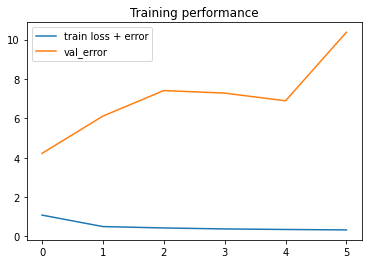

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

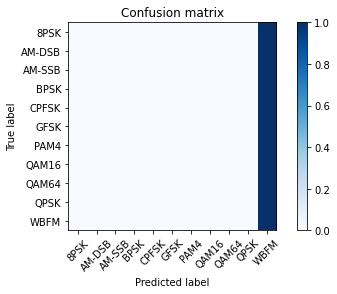

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08828894564027727


Overall Accuracy:  0.09034608378870675


Overall Accuracy:  0.08768115942028985


Overall Accuracy:  0.0866838804869052


Overall Accuracy:  0.08516780945507037


Overall Accuracy:  0.08868613138686131


Overall Accuracy:  0.09140568099053169


Overall Accuracy:  0.08946980854197349


Overall Accuracy:  0.09381663113006397


Overall Accuracy:  0.09143686502177069


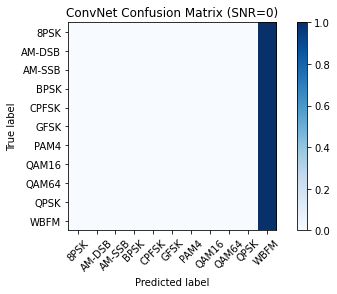

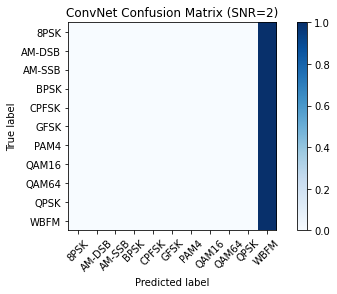

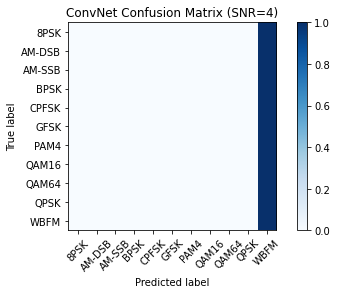

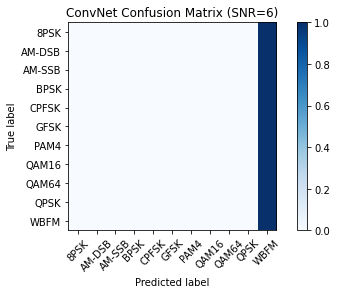

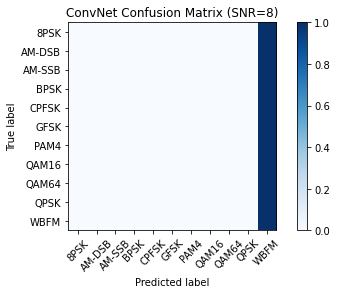

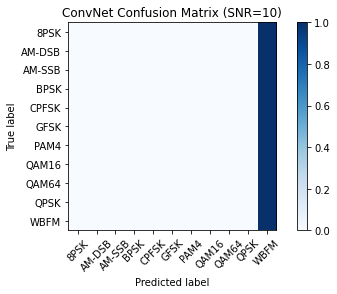

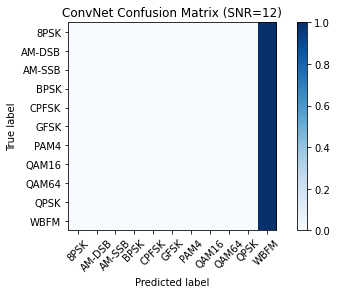

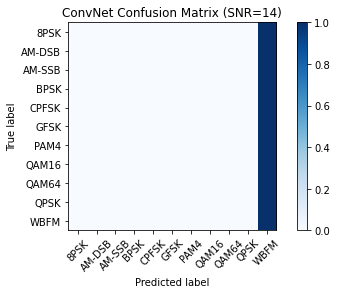

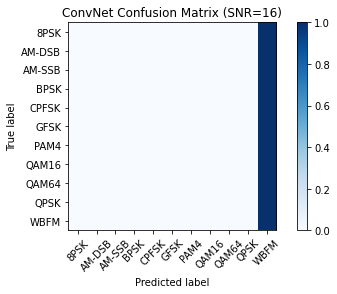

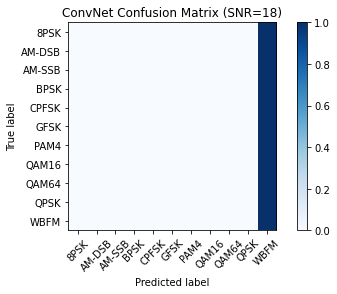

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,8,8,8,8,9,8,9,9


In [18]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

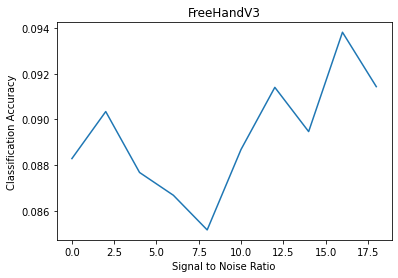

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)